In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

In [56]:
data = pd.read_csv('level_6_meta.csv', index_col=0)

In [57]:
data.head()

,group,d__Eukaryota;__;__;__;__;__,Unassigned;__;__;__;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptococcales;f__Peptococcaceae;g__Peptococcus,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Calditerricola,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__UBA1819,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Anaerofilum,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Fournierella,...,BioSample,env_medium,Experiment,geo_loc_name_country,geo_loc_name_country_continent,Host,Instrument,LibraryLayout,Organism,SRA Study
index,,,,,,,,,,,,,,,,,,,,,
DRR236281,OG,2,0,4,0,2070,81,3177,9,13,...,SAMD00233992,feces,DRX226465,Japan,Asia,Homo sapiens,Illumina MiSeq,PAIRED,human gut metagenome,DRP011713
DRR236282,OG,43,4,0,0,3794,0,3008,0,0,...,SAMD00233993,feces,DRX226466,Japan,Asia,Homo sapiens,Illumina MiSeq,PAIRED,human gut metagenome,DRP011713
DRR236283,NOG,0,0,0,92,0,1091,458,12,92,...,SAMD00233994,feces,DRX226467,Japan,Asia,Homo sapiens,Illumina MiSeq,PAIRED,human gut metagenome,DRP011713
DRR236284,NOG,0,6,0,0,26,0,758,0,0,...,SAMD00233995,feces,DRX226468,Japan,Asia,Homo sapiens,Illumina MiSeq,PAIRED,human gut metagenome,DRP011713
DRR236285,NOG,0,4,0,0,1134,35,3310,0,0,...,SAMD00233996,feces,DRX226469,Japan,Asia,Homo sapiens,Illumina MiSeq,PAIRED,human gut metagenome,DRP011713


In [58]:
data.drop(['BioSample', 'env_medium', 'Experiment', 'geo_loc_name_country',
       'geo_loc_name_country_continent', 'Host', 'Instrument', 'LibraryLayout',
       'Organism', 'SRA Study', 'run', 'Sample Name', 'born', 'sex', 'Bases'], axis=1, inplace=True)

In [70]:
data.shape

(60, 272)

In [96]:
data_relative = data.iloc[:, 1:].div(data.iloc[:, 1:].sum(axis=0), axis=1)
data_relative.insert(0, 'group', data['group']) 

In [97]:
#data_relative

In [140]:
min_abundance_threshold = 0.9

# Calculate the max values for all columns 
max_values = data_relative.iloc[:, 1:].max(axis=0) > min_abundance_threshold
mask_abundance = [True] + max_values.tolist()

# Filter the DataFrame
data_filtered = data_relative.loc[:, mask_abundance]

In [141]:
data_filtered.shape

(60, 55)

In [142]:
ogimi = data_filtered[data_filtered["group"]=="OG"]
non_ogimi = data_filtered[data_filtered["group"]== "NOG"]

In [143]:
ogimi.shape, non_ogimi.shape

((40, 55), (20, 55))

In [144]:
ogimi.drop('group', axis=1, inplace=True)
non_ogimi.drop('group', axis=1, inplace=True)

/var/folders/_4/p4p8llrs7s97qrcpyfmwrnx00000gn/T/ipykernel_47875/3287280106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ogimi.drop('group', axis=1, inplace=True)
/var/folders/_4/p4p8llrs7s97qrcpyfmwrnx00000gn/T/ipykernel_47875/3287280106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ogimi.drop('group', axis=1, inplace=True)


In [145]:
ogimi.shape, non_ogimi.shape

((40, 54), (20, 54))

In [146]:
# define jsd 
def jensenshannon(p, q, base=None, *, axis=0, keepdims=False):
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p, axis=axis, keepdims=True)
    q = q / np.sum(q, axis=axis, keepdims=True)
    m = (p + q) / 2.0
    left = rel_entr(p, m)
    right = rel_entr(q, m)
    left_sum = np.sum(left, axis=axis, keepdims=keepdims)
    right_sum = np.sum(right, axis=axis, keepdims=keepdims)
    js = left_sum + right_sum
    if base is not None:
        js /= np.log(base)
    return np.sqrt(js / 2.0)

# func for JSD between two distributions
def compute_jsd(p_values, q_values):
    p_values /= p_values.sum()
    q_values /= q_values.sum()
    return jensenshannon(p_values, q_values)

In [147]:
# Normalize 
scaler = MinMaxScaler()
ogimi_scaled = scaler.fit_transform(ogimi)
non_ogimi_scaled = scaler.transform(non_ogimi)

In [148]:
jsd_scores = {}

# Compute JSD for each feature
for feature in ogimi.columns:
    # Calculate histograms for normal and anomaly carriers
    p, _ = np.histogram(ogimi_scaled[:, ogimi.columns.get_loc(feature)], bins=50, range=(0, 1), density=True)
    q, _ = np.histogram(non_ogimi_scaled[:, ogimi.columns.get_loc(feature)], bins=50, range=(0, 1), density=True)
    
    # Compute JSD 
    jsd_scores[feature] = compute_jsd(p, q)


# JSD scores
print("Jensen-Shannon Divergence Scores for Features:")
for feature, score in jsd_scores.items():
    print(f"{feature}: {score:.4f}")


jsd_df = pd.DataFrame(list(jsd_scores.items()), columns=['Feature', 'JSD'])
jsd_df = jsd_df.sort_values(by='JSD', ascending=False)

Jensen-Shannon Divergence Scores for Features:
d__Bacteria;p__Elusimicrobiota;c__Elusimicrobia;o__Elusimicrobiales;f__Elusimicrobiaceae;g__Elusimicrobium: 0.0935
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas: 0.1635
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter: 0.1329
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__Coprobacter: 0.1329
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__uncultured: 0.0935
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotellaceae_UCG-001: 0.0935
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;__: 0.0935
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;__: 0.1329
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sph

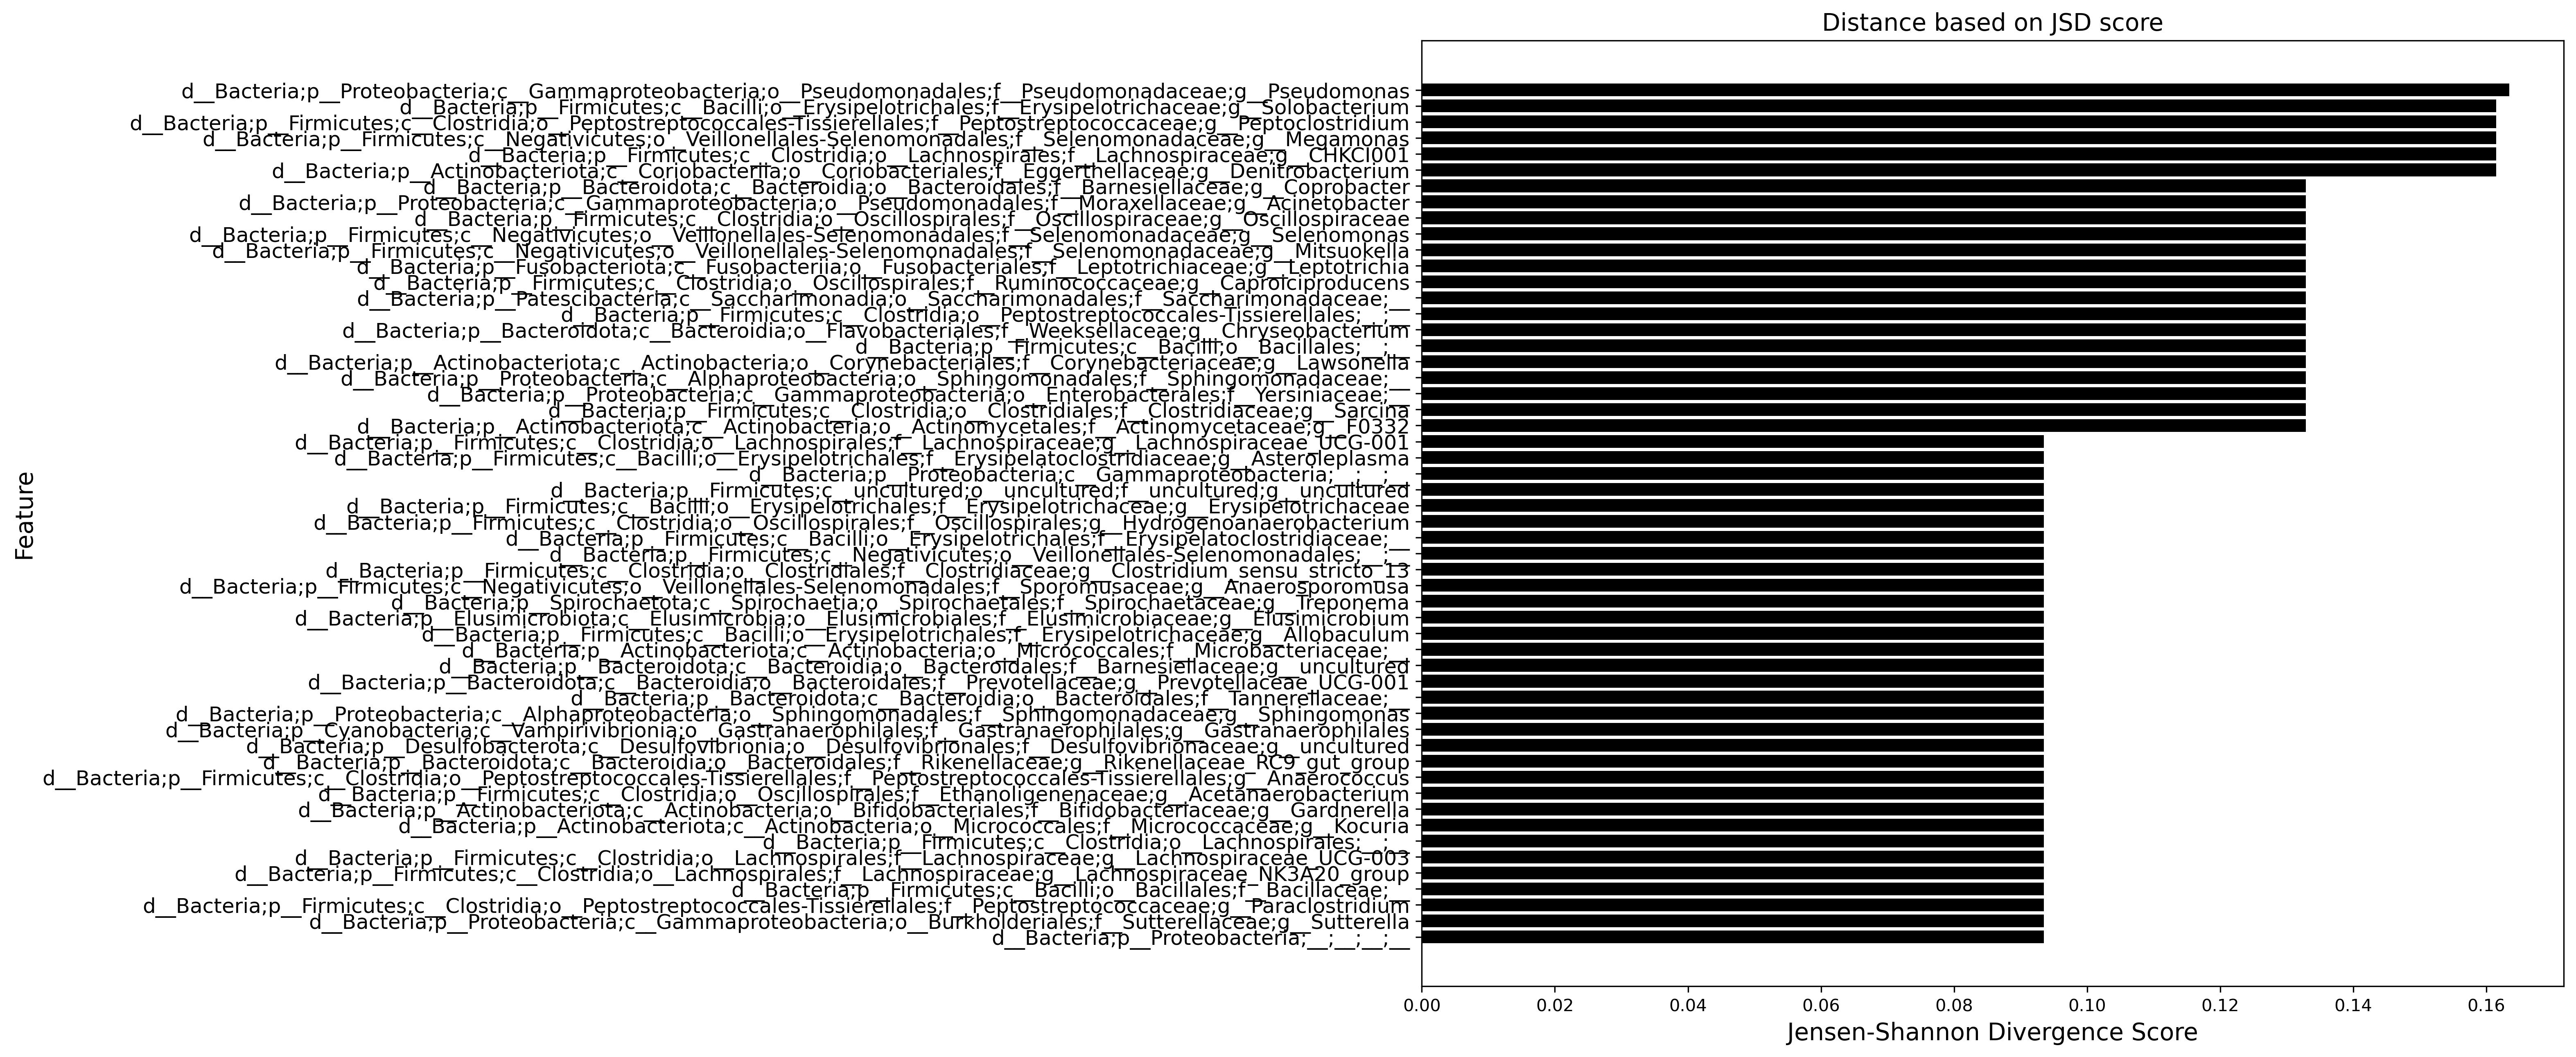

In [149]:
# Visualization

plt.figure(figsize=(12, 10), dpi=300)
plt.barh(jsd_df['Feature'], jsd_df['JSD'], color='black')
plt.xlabel('Jensen-Shannon Divergence Score', fontsize= 14)
plt.ylabel('Feature', fontsize= 14)
plt.title('Distance based on JSD score', fontsize = 14)
plt.gca().invert_yaxis()
plt.yticks(fontsize=12)
#plt.xlim([0, 1]) 
plt.show()

In [159]:
feat = jsd_df[jsd_df["JSD"]>=0.15]

In [160]:
feat

,Feature,JSD
1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.163474
30,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysip...,0.161475
27,d__Bacteria;p__Firmicutes;c__Clostridia;o__Pep...,0.161475
15,d__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.161475
23,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...,0.161475
17,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,0.161475


In [153]:
max = jsd_df["JSD"].max()
print(max)
min = jsd_df["JSD"].min()
print(min)

0.16347392354958787
0.0935064478735678
